In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import scipy.stats
import tqdm.notebook
import h5py
import celltypist
import pickle

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


### Define paths and constants

In [2]:
in_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/"
cache_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/covid_flu_cache.h5ad"
out_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/covid_flu_processed.h5"

In [3]:
cluster_markers_dir = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/cluster_markers/"

### Import data

In [4]:
adata = sc.read_10x_mtx(
    in_path, prefix="GSE149689_", var_names="gene_symbols", cache=True
)
adata.var_names_make_unique()
adata

... reading from cache file cache/gstore-data-resbioai-tsenga5-branched_diffusion-data-scrna-covid_flu-GSE149689_matrix.h5ad


AnnData object with n_obs × n_vars = 85144 × 33538
    var: 'gene_ids', 'feature_types'

In [5]:
cluster_marker_tables = []
file_names = sorted(os.listdir(cluster_markers_dir), key=(lambda k: int(k.split(".")[0].split("_")[1])))
for file_name in file_names:
    if file_name.endswith(".csv"):
        cluster_marker_tables.append(
            pd.read_csv(os.path.join(cluster_markers_dir, file_name), sep=",", header=0)
        )

### Pre-processing 1: initial filtering

normalizing counts per cell
    finished (0:00:01)


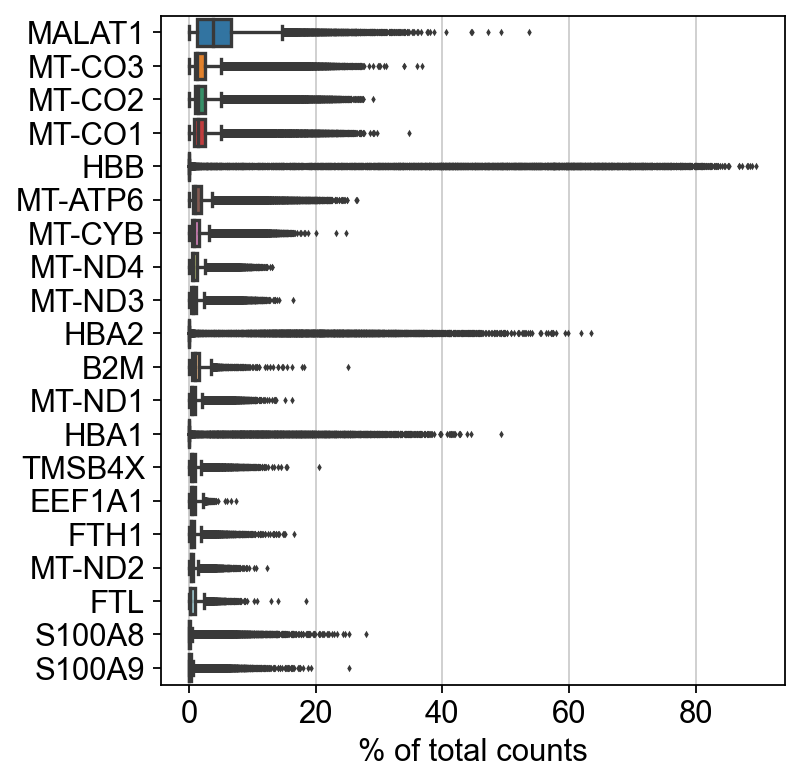

In [6]:
# Plot highest-expression genes
sc.pl.highest_expr_genes(adata, n_top=20)

In [7]:
# Filter out cells with too few genes and genes with too few cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 8615 cells that have less than 200 genes expressed
filtered out 10227 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 76529 × 23311
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

... storing 'feature_types' as categorical


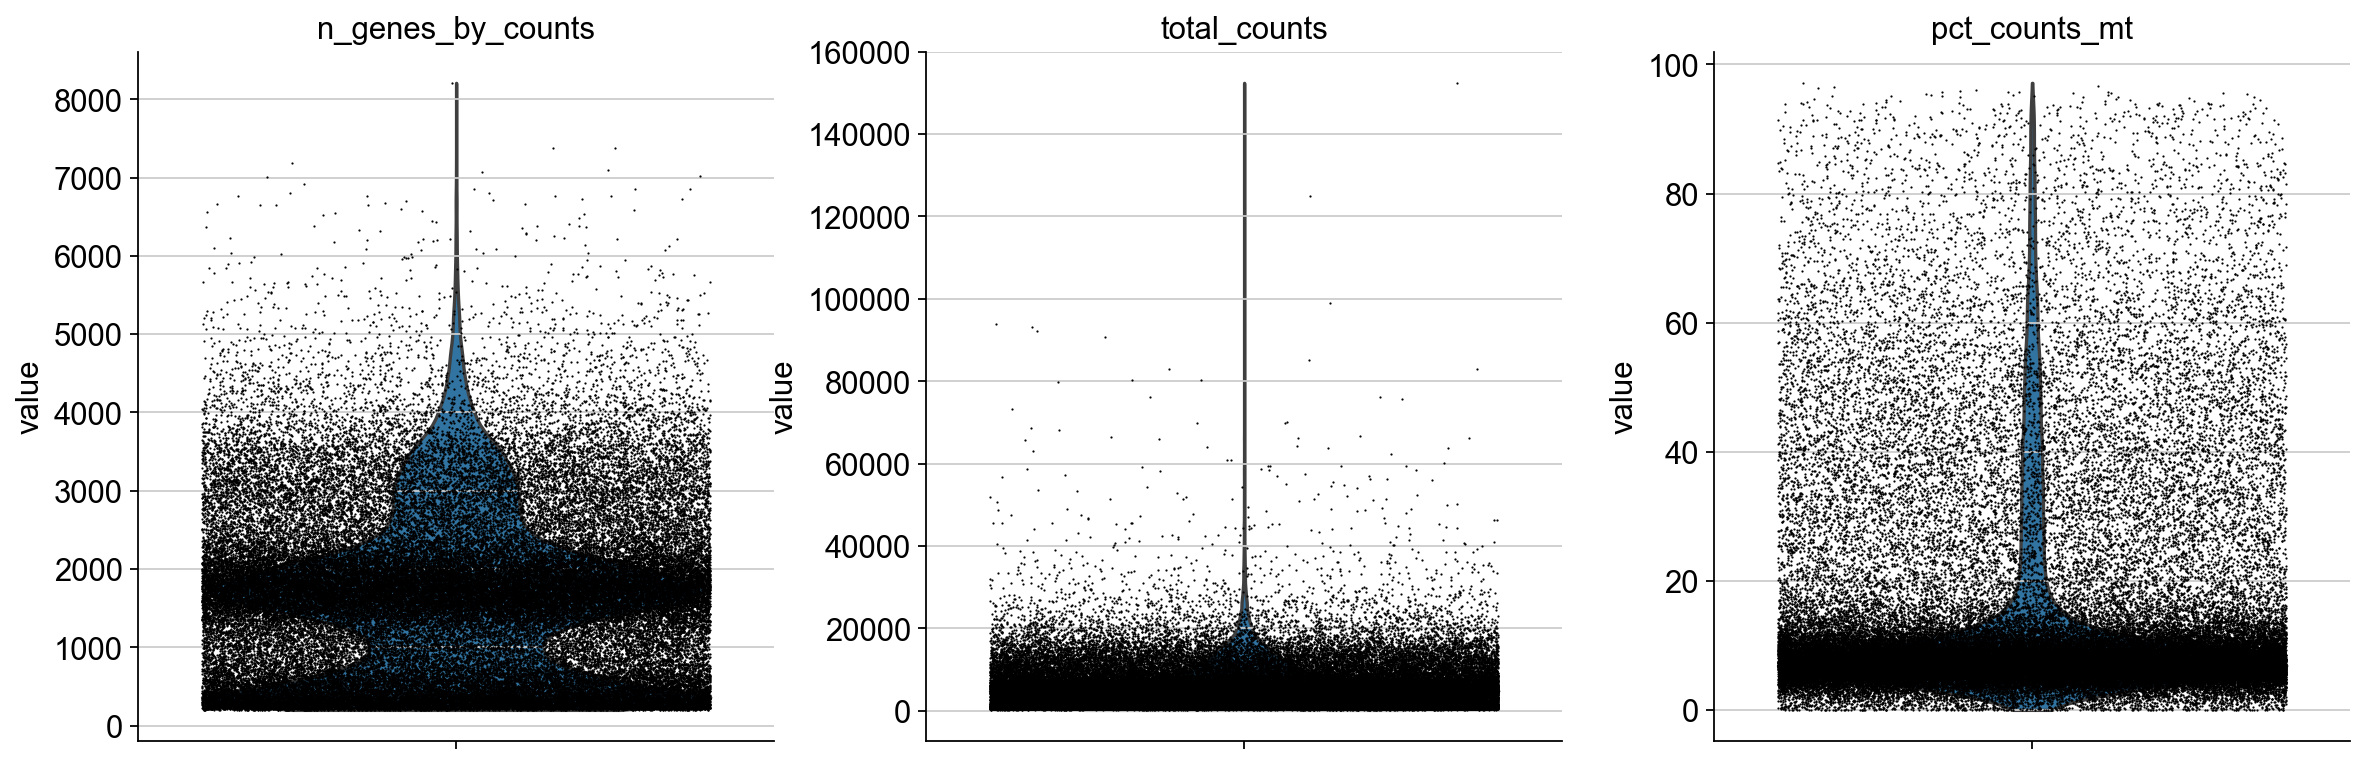

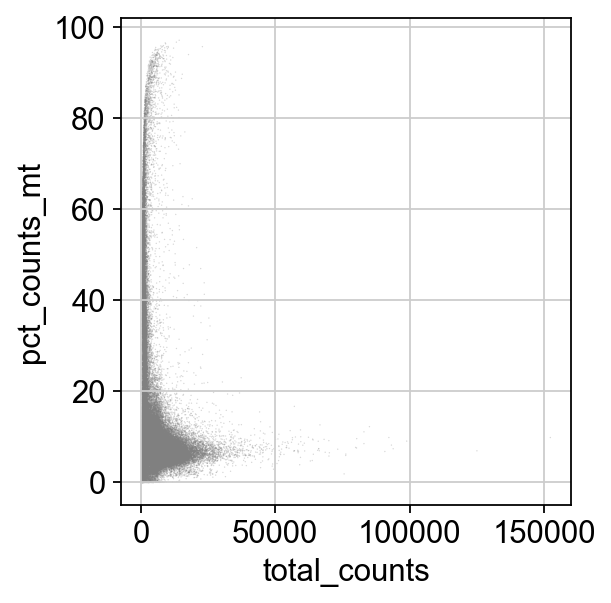

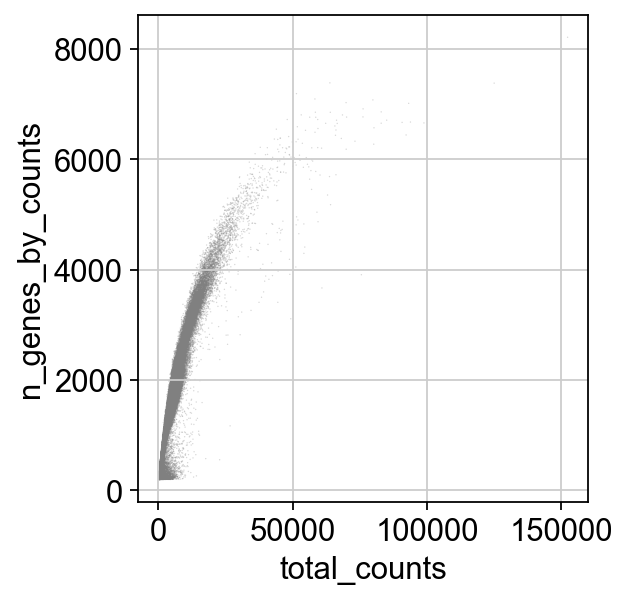

View of AnnData object with n_obs × n_vars = 37102 × 23311
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [8]:
# Filter out cells with too many mitochondrial genes or too many total counts

adata.var["mt"] = adata.var_names.str.startswith("MT-")  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(
    adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4, multi_panel=True
)

sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", alpha=0.3)
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", alpha=0.3)

adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata

### Pre-processing 2: assign cell-type labels

In [9]:
# Save a copy of current data (before normalization)
adata.raw = adata

In [10]:
# Normalize total counts to 10000, and turn to log-scale
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [11]:
# Assign each cell a cell type using celltypist

# Import the fine-grained celltypist model
model_path = "/gstore/home/tsenga5/branched_diffusion/data/scrna/celltypist_models/Immune_All_Low.pkl"
with open(model_path, "rb") as f:
    obj = pickle.load(f)
    model = celltypist.models.Model(obj["Model"], obj["Scaler_"], obj["description"])
    
predictions = celltypist.annotate(
    adata, model=model, majority_voting=True
)

adata = predictions.to_adata()

🔬 Input data has 37102 cells and 23311 genes
🔗 Matching reference genes in the model
🧬 5745 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering


filtered out 2984 genes that are detected in less than 5 cells
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 50


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)


⛓️ Over-clustering input data with resolution set to 15


running Leiden clustering
    finished: found 234 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:11)


🗳️ Majority voting the predictions
✅ Majority voting done!


In [12]:
adata.obs["cell_cluster"] = adata.obs.loc[
    adata.obs.index, "majority_voting"
]

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_cluster']`


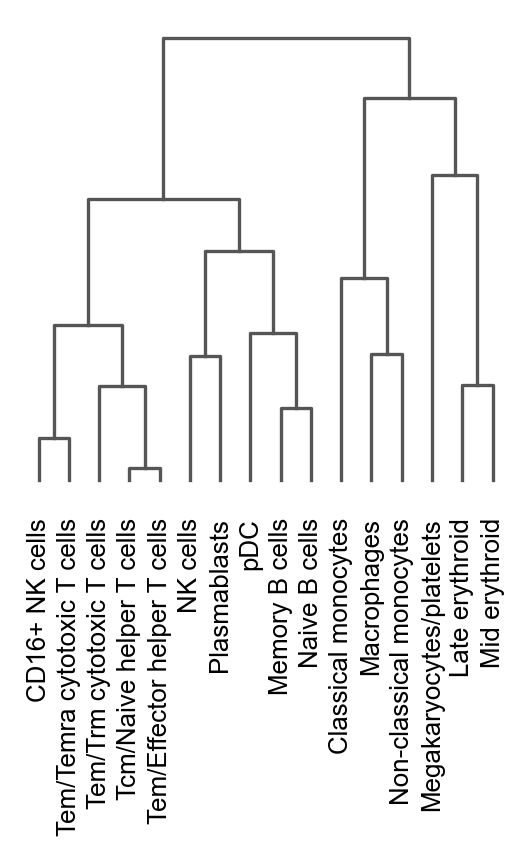

<AxesSubplot:>

In [13]:
# Visualize hierarchy
sc.pl.dendrogram(adata, groupby="cell_cluster")

### Pre-processing 3: other filtering

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


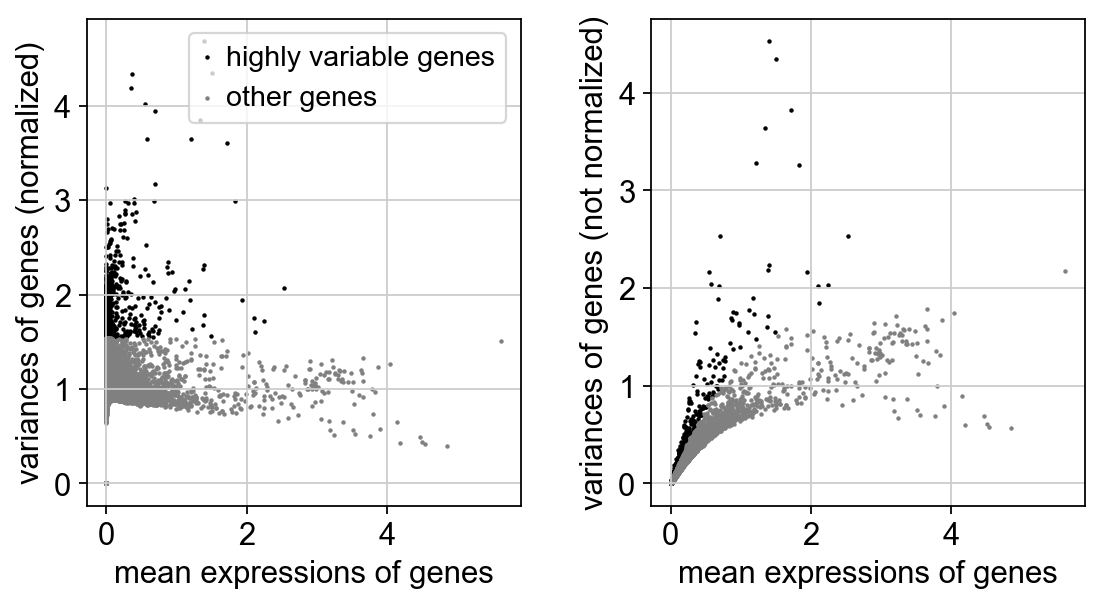

View of AnnData object with n_obs × n_vars = 37102 × 1000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'cell_cluster'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'neighbors', 'leiden', 'dendrogram_cell_cluster', 'hvg'
    obsm: 'X_pca'
    obsp: 'connectivities', 'distances'

In [14]:
# Keep only highly variable genes
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor="seurat_v3")
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
adata

In [15]:
# Scale to unit variance and cut off anything outside 10 standard deviations
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


### Clustering

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


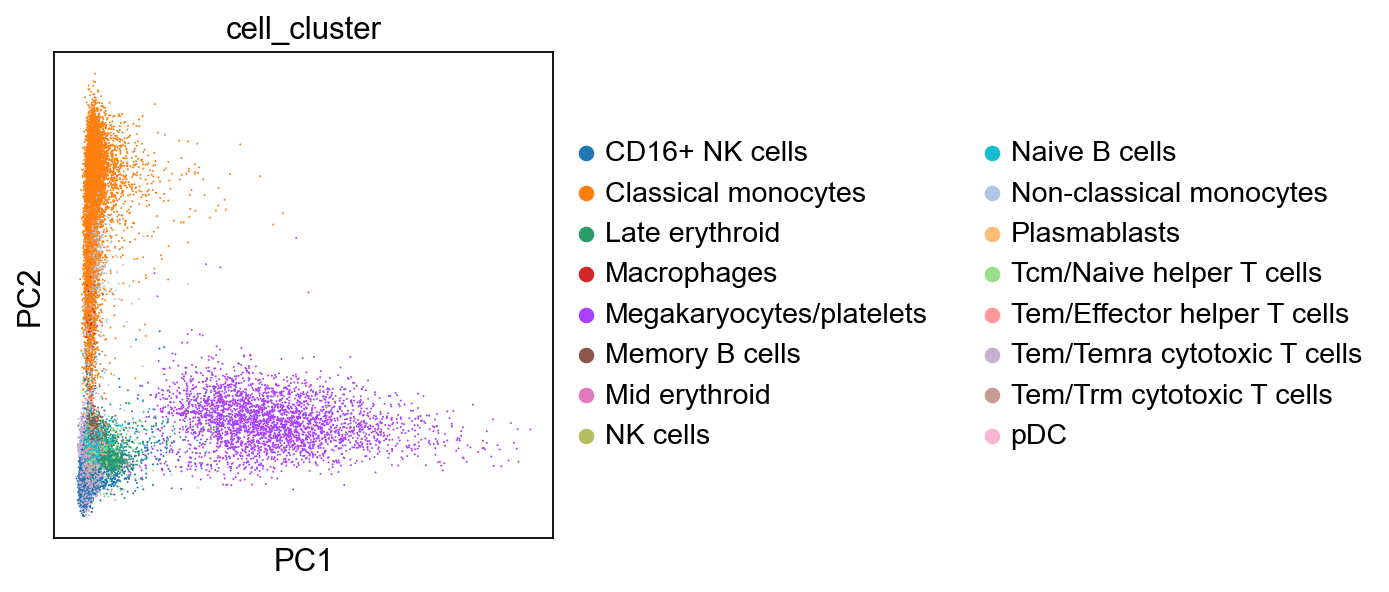

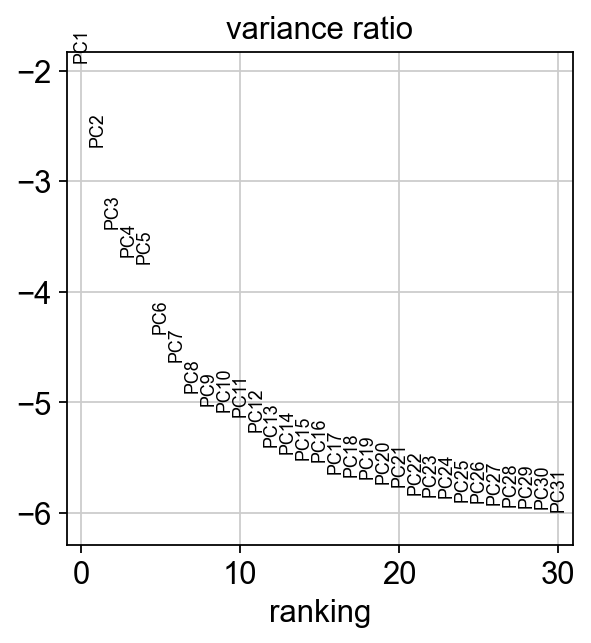

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [16]:
# Compute neighborhood graph on PC-reduced representations
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca(adata, color="cell_cluster")
sc.pl.pca_variance_ratio(adata, log=True)

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [17]:
# Compute UMAP
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:43)


running Leiden clustering
    finished: found 27 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


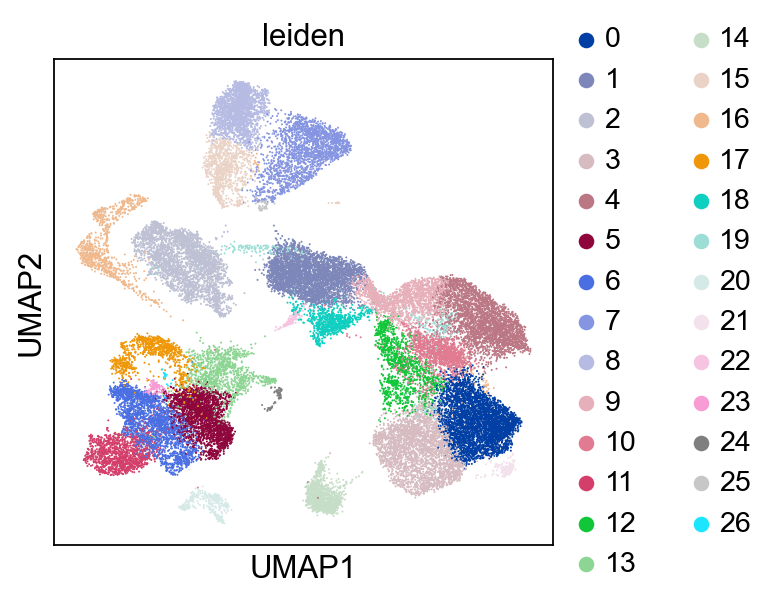

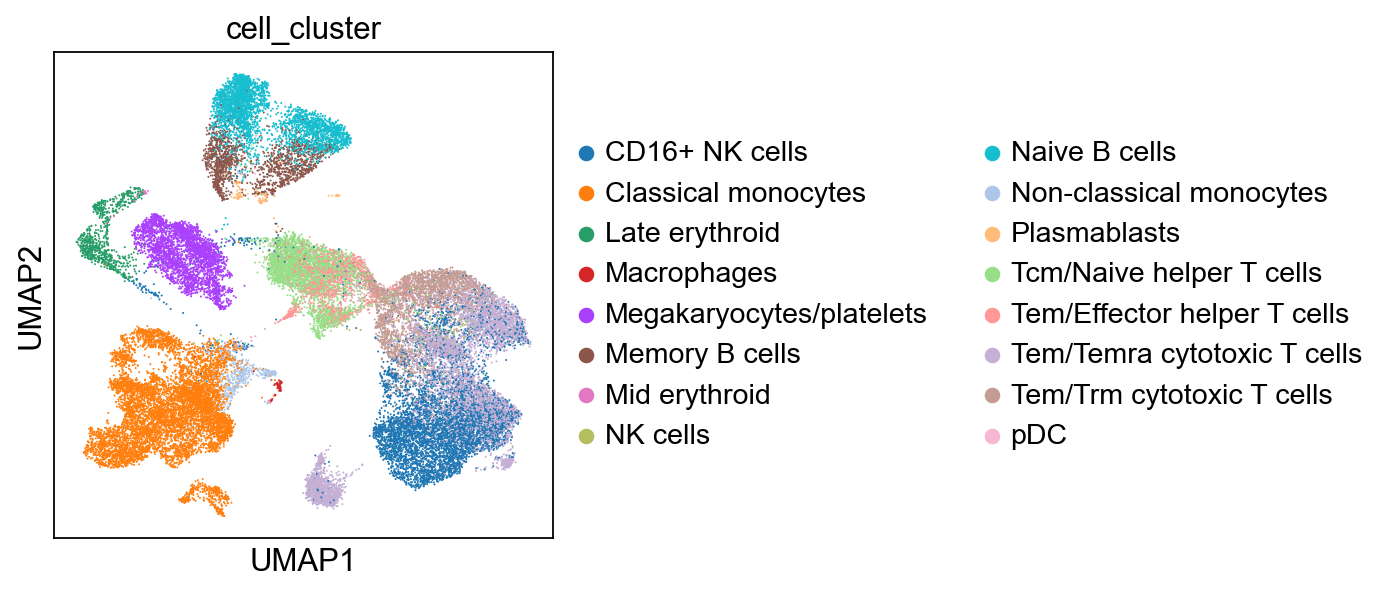

In [18]:
# Plot UMAP, coloring by Leiden clusters and by mapped clusters
sc.tl.leiden(adata)
sc.pl.umap(adata, color="leiden")
sc.pl.umap(adata, color="cell_cluster")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:13)


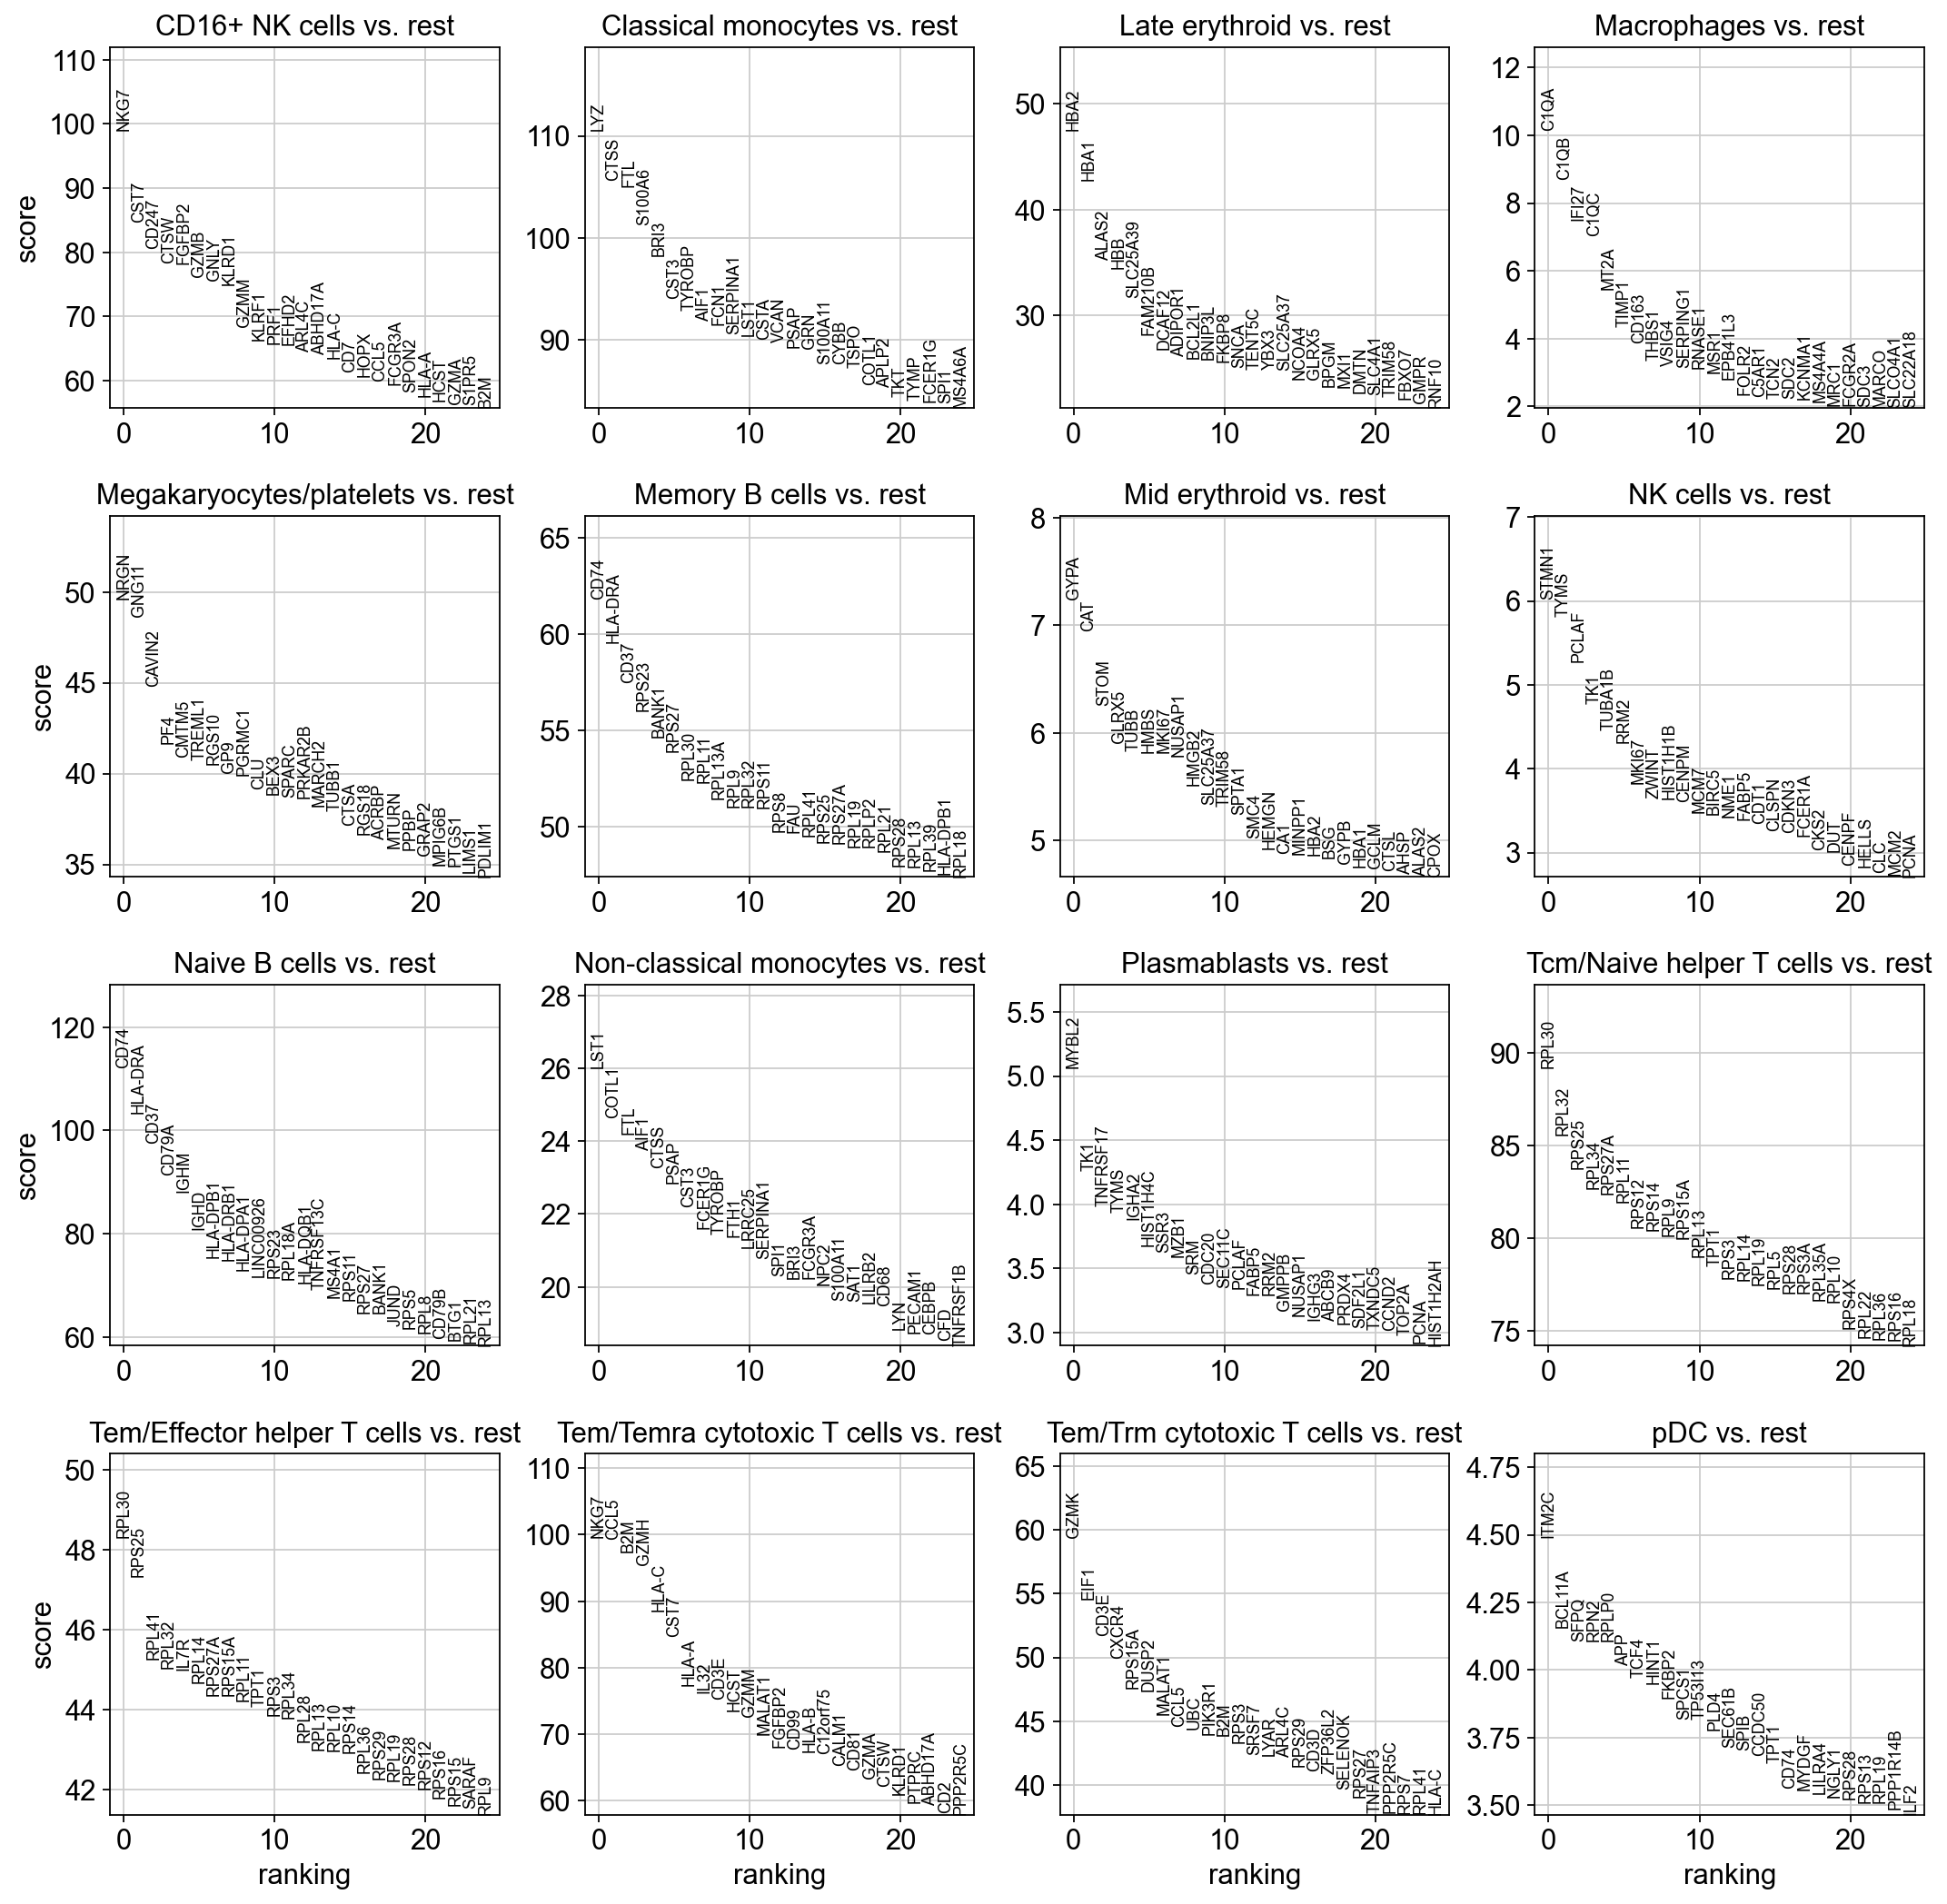

In [19]:
sc.tl.rank_genes_groups(adata, "cell_cluster", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

### Identify marker genes in cell-type clusters

In [20]:
# Save results
adata.write(out_path)

### Write out data file

In [21]:
# Map each cell-cluster name to a numerical ID
cell_clusters, counts = np.unique(adata.obs["cell_cluster"], return_counts=True)
inds = np.flip(np.argsort(counts))
cell_clusters = cell_clusters[inds]
cell_cluster_dict = {c : i for i, c in enumerate(cell_clusters)}
adata.obs["cell_cluster_id"] = adata.obs["cell_cluster"].apply(lambda c: cell_cluster_dict[c])

In [22]:
with h5py.File(out_path, "w") as f:
    f.create_dataset("x", data=adata.X, compression="gzip")
    f.create_dataset("gene_names", data=np.array(adata.var["gene_ids"].index), compression="gzip")
    f.create_dataset("gene_ids", data=np.array(adata.var["gene_ids"]), compression="gzip")
    f.create_dataset("cell_id", data=np.array(adata.obs["cell_cluster"].index), dtype=h5py.string_dtype(encoding="ascii"), compression="gzip")
    f.create_dataset("cell_cluster_id", data=np.array(adata.obs["cell_cluster_id"]).astype(int), compression="gzip")
    f.create_dataset("cell_cluster_name", data=np.array(adata.obs["cell_cluster"]), dtype=h5py.string_dtype(encoding="ascii"), compression="gzip")